# RACHEL

In [1]:
# import dependencies
import requests
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# File to Load
drug_deaths_to_load = Path('Data') / 'opioid_death_counts.csv'

# Import Census API Key
from api_keys import census_api_key

# Replace 'YOUR_API_KEY' with your actual census API key
API_KEY = census_api_key
state = 'state:01,02,04,05,06,08,09,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56'
education_2022_url = f'https://api.census.gov/data/2022/acs/acs1?get=NAME,group(B15003)&for={state}&key={census_api_key}'
education_2021_url = f'https://api.census.gov/data/2021/acs/acs1?get=NAME,group(B15003)&for={state}&key={census_api_key}'
education_2019_url = f'https://api.census.gov/data/2019/acs/acs1?get=NAME,group(B15003)&for={state}&key={census_api_key}'
education_2018_url = f'https://api.census.gov/data/2018/acs/acs1?get=NAME,group(B15003)&for={state}&key={census_api_key}'
education_2017_url = f'https://api.census.gov/data/2017/acs/acs1?get=NAME,group(B15003)&for={state}&key={census_api_key}'

# print(f'Educational Attainment 2022: {education_2022_url}\n')
# print(f'Educational Attainment 2021: {education_2021_url}\n')
# print(f'Educational Attainment 2019: {education_2019_url}\n')
# print(f'Educational Attainment 2018: {education_2018_url}\n')
# print(f'Educational Attainment 2017: {education_2017_url}\n')

education_2022_json = requests.get(education_2022_url).json()
education_2021_json = requests.get(education_2021_url).json()
education_2019_json = requests.get(education_2019_url).json()
education_2018_json = requests.get(education_2018_url).json()
education_2017_json = requests.get(education_2017_url).json()


In [2]:
#Convert 2022 JSON to Pandas Dataframe
education_2022_df = pd.DataFrame(requests.get(education_2022_url).json()[1:], columns=requests.get(education_2022_url).json()[0])

# Drop one of the duplicate 'NAME' columns
education_2022_df = education_2022_df.loc[:, ~education_2022_df.columns.duplicated()]

# Convert the relevant columns to numeric, forcing errors to NaN if necessary, and grouping relevant data
cols_to_sum = ['B15003_002E','B15003_003E','B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E', 'B15003_009E','B15003_010E', 'B15003_011E', 'B15003_012E','B15003_013E', 'B15003_014E', 'B15003_015E', 'B15003_016E']
education_2022_df[cols_to_sum] = education_2022_df[cols_to_sum].apply(pd.to_numeric, errors='coerce')

cols_to_sum_1 = ['B15003_017E', 'B15003_018E','B15003_019E', 'B15003_020E',]
education_2022_df[cols_to_sum_1] = education_2022_df[cols_to_sum_1].apply(pd.to_numeric, errors='coerce')

cols_to_sum_2 = [ 'B15003_021E','B15003_022E', 'B15003_023E','B15003_024E','B15003_025E']
education_2022_df[cols_to_sum_2] = education_2022_df[cols_to_sum_2].apply(pd.to_numeric, errors='coerce')

# Use .loc to set the new column by summing the specified columns
education_2022_df.loc[:, 'No High School Degree'] = education_2022_df[cols_to_sum].sum(axis=1)
education_2022_df.loc[:, 'High School Diploma or GED'] = education_2022_df[cols_to_sum_1].sum(axis=1)
education_2022_df.loc[:, 'College Degree or greater'] = education_2022_df[cols_to_sum_2].sum(axis=1)

# Drop the original columns if they are no longer needed
education_2022_df.drop(cols_to_sum, axis=1, inplace=True)
education_2022_df.drop(cols_to_sum_1, axis=1, inplace=True)
education_2022_df.drop(cols_to_sum_2, axis=1, inplace=True)

# Rename columns and make a copy of the DataFrame
education_2022_df_cleaned = education_2022_df.rename(columns={
    'B15003_001E': 'Total Surveyed',
    'NAME':'State'
}).copy() 

education_2022_df_cleaned ['Year'] = 2022

education_2022_df_final = education_2022_df_cleaned[[
    'Year',
    'State',
    'No High School Degree',
    'High School Diploma or GED',
    'College Degree or greater',
    'Total Surveyed'
]].copy()  # Use .copy() to ensure it's a copy

education_2022_df_final.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2022,Alabama,389297,1773299,1312328,3474924
1,2022,Alaska,32669,258533,198016,489218
2,2022,Arizona,548248,2363882,2141526,5053656
3,2022,Arkansas,223437,1143746,690441,2057624
4,2022,California,4115683,10699709,12051381,26866773


In [3]:
# Columns to convert to numeric
columns_to_convert = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater','Total Surveyed']

# Convert columns to numeric, forcing errors to NaN if necessary
education_2022_df_final[columns_to_convert] = education_2022_df_final[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Columns to convert to percentages
columns_to_percent = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater']

# Convert to percentages
percent_of_total_2022 = education_2022_df_final.copy()
percent_of_total_2022[columns_to_convert] = education_2022_df_final[columns_to_convert].div(education_2022_df_final['Total Surveyed'], axis=0) * 100

# Round to two decimal places and format with percentage sign for specific columns
percent_of_total_2022[columns_to_percent] = percent_of_total_2022[columns_to_percent].apply(lambda col: col.map(lambda x: f"{x:.2f}"))

# Display the new DataFrame with percentages
percent_of_total_2022.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2022,Alabama,11.20,51.03,37.77,100.0
1,2022,Alaska,6.68,52.85,40.48,100.0
2,2022,Arizona,10.85,46.78,42.38,100.0
3,2022,Arkansas,10.86,55.59,33.56,100.0
4,2022,California,15.32,39.83,44.86,100.0


In [4]:
#Convert 2021 JSON to Pandas Dataframe
education_2021_df = pd.DataFrame(requests.get(education_2021_url).json()[1:], columns=requests.get(education_2021_url).json()[0])

# Drop one of the duplicate 'NAME' columns
education_2021_df = education_2021_df.loc[:, ~education_2021_df.columns.duplicated()]

# Convert the relevant columns to numeric, forcing errors to NaN if necessary, and grouping relevant data
cols_to_sum = ['B15003_002E','B15003_003E','B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E', 'B15003_009E','B15003_010E', 'B15003_011E', 'B15003_012E','B15003_013E', 'B15003_014E', 'B15003_015E', 'B15003_016E']
education_2021_df[cols_to_sum] = education_2021_df[cols_to_sum].apply(pd.to_numeric, errors='coerce')

cols_to_sum_1 = ['B15003_017E', 'B15003_018E','B15003_019E', 'B15003_020E',]
education_2021_df[cols_to_sum_1] = education_2021_df[cols_to_sum_1].apply(pd.to_numeric, errors='coerce')

cols_to_sum_2 = [ 'B15003_021E','B15003_022E', 'B15003_023E','B15003_024E','B15003_025E']
education_2021_df[cols_to_sum_2] = education_2021_df[cols_to_sum_2].apply(pd.to_numeric, errors='coerce')

# Use .loc to set the new column by summing the specified columns
education_2021_df.loc[:, 'No High School Degree'] = education_2021_df[cols_to_sum].sum(axis=1)
education_2021_df.loc[:, 'High School Diploma or GED'] = education_2021_df[cols_to_sum_1].sum(axis=1)
education_2021_df.loc[:, 'College Degree or greater'] = education_2021_df[cols_to_sum_2].sum(axis=1)

# Drop the original columns if they are no longer needed
education_2021_df.drop(cols_to_sum, axis=1, inplace=True)
education_2021_df.drop(cols_to_sum_1, axis=1, inplace=True)
education_2021_df.drop(cols_to_sum_2, axis=1, inplace=True)

# Rename columns and make a copy of the DataFrame
education_2021_df_cleaned = education_2021_df.rename(columns={
    'B15003_001E': 'Total Surveyed',
    'NAME':'State'
}).copy() 

education_2021_df_cleaned ['Year'] = 2021

education_2021_df_final = education_2021_df_cleaned[[
    'Year',
    'State',
    'No High School Degree',
    'High School Diploma or GED',
    'College Degree or greater',
    'Total Surveyed'
]].copy()  # Use .copy() to ensure it's a copy

education_2021_df_final.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2021,Alabama,416467,1784947,1249794,3451208
1,2021,Arizona,549363,2348548,2082386,4980297
2,2021,Arkansas,230890,1130297,676576,2037763
3,2021,California,4184879,10866898,11858092,26909869
4,2021,Colorado,305974,1607811,2130397,4044182


In [5]:
# Columns to convert to numeric
columns_to_convert = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater','Total Surveyed']

# Convert columns to numeric, forcing errors to NaN if necessary
education_2021_df_final[columns_to_convert] = education_2021_df_final[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Columns to convert to percentages
columns_to_percent = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater']

# Convert to percentages
percent_of_total_2021 = education_2021_df_final.copy()
percent_of_total_2021[columns_to_convert] = education_2021_df_final[columns_to_convert].div(education_2021_df_final['Total Surveyed'], axis=0) * 100

# Round to two decimal places and format with percentage sign for specific columns
percent_of_total_2021[columns_to_percent] = percent_of_total_2021[columns_to_percent].apply(lambda col: col.map(lambda x: f"{x:.2f}"))

# Display the new DataFrame with percentages
percent_of_total_2021.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2021,Alabama,12.07,51.72,36.21,100.0
1,2021,Arizona,11.03,47.16,41.81,100.0
2,2021,Arkansas,11.33,55.47,33.20,100.0
3,2021,California,15.55,40.38,44.07,100.0
4,2021,Colorado,7.57,39.76,52.68,100.0


In [6]:
#Convert 2019 JSON to Pandas Dataframe
education_2019_df = pd.DataFrame(requests.get(education_2019_url).json()[1:], columns=requests.get(education_2019_url).json()[0])

# Drop one of the duplicate 'NAME' columns
education_2019_df = education_2019_df.loc[:, ~education_2019_df.columns.duplicated()]

# Convert the relevant columns to numeric, forcing errors to NaN if necessary, and grouping relevant data
cols_to_sum = ['B15003_002E','B15003_003E','B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E', 'B15003_009E','B15003_010E', 'B15003_011E', 'B15003_012E','B15003_013E', 'B15003_014E', 'B15003_015E', 'B15003_016E']
education_2019_df[cols_to_sum] = education_2019_df[cols_to_sum].apply(pd.to_numeric, errors='coerce')

cols_to_sum_1 = ['B15003_017E', 'B15003_018E','B15003_019E', 'B15003_020E',]
education_2019_df[cols_to_sum_1] = education_2019_df[cols_to_sum_1].apply(pd.to_numeric, errors='coerce')

cols_to_sum_2 = [ 'B15003_021E','B15003_022E', 'B15003_023E','B15003_024E','B15003_025E']
education_2019_df[cols_to_sum_2] = education_2019_df[cols_to_sum_2].apply(pd.to_numeric, errors='coerce')

# Use .loc to set the new column by summing the specified columns
education_2019_df.loc[:, 'No High School Degree'] = education_2019_df[cols_to_sum].sum(axis=1)
education_2019_df.loc[:, 'High School Diploma or GED'] = education_2019_df[cols_to_sum_1].sum(axis=1)
education_2019_df.loc[:, 'College Degree or greater'] = education_2019_df[cols_to_sum_2].sum(axis=1)

# Drop the original columns if they are no longer needed
education_2019_df.drop(cols_to_sum, axis=1, inplace=True)
education_2019_df.drop(cols_to_sum_1, axis=1, inplace=True)
education_2019_df.drop(cols_to_sum_2, axis=1, inplace=True)

# Rename columns and make a copy of the DataFrame
education_2019_df_cleaned = education_2019_df.rename(columns={
    'B15003_001E': 'Total Surveyed',
    'NAME':'State'
}).copy() 

education_2019_df_cleaned ['Year'] = 2019

education_2019_df_final = education_2019_df_cleaned[[
    'Year',
    'State',
    'No High School Degree',
    'High School Diploma or GED',
    'College Degree or greater',
    'Total Surveyed'
]].copy()  # Use .copy() to ensure it's a copy

education_2019_df_final.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2019,Mississippi,290917,1039548,649199,1979664
1,2019,Missouri,391815,2209345,1605002,4206162
2,2019,Montana,42682,380720,318548,741950
3,2019,Nebraska,101272,606722,563776,1271770
4,2019,Nevada,280915,1119163,736388,2136466


In [7]:
# Columns to convert to numeric
columns_to_convert = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater','Total Surveyed']

# Convert columns to numeric, forcing errors to NaN if necessary
education_2019_df_final[columns_to_convert] = education_2019_df_final[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Columns to convert to percentages
columns_to_percent = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater']

# Convert to percentages
percent_of_total_2019 = education_2021_df_final.copy()
percent_of_total_2019[columns_to_convert] = education_2019_df_final[columns_to_convert].div(education_2019_df_final['Total Surveyed'], axis=0) * 100

# Round to two decimal places and format with percentage sign for specific columns
percent_of_total_2019[columns_to_percent] = percent_of_total_2019[columns_to_percent].apply(lambda col: col.map(lambda x: f"{x:.2f}%"))

# Display the new DataFrame with percentages
percent_of_total_2019.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2021,Alabama,14.70%,52.51%,32.79%,100.0
1,2021,Arizona,9.32%,52.53%,38.16%,100.0
2,2021,Arkansas,5.75%,51.31%,42.93%,100.0
3,2021,California,7.96%,47.71%,44.33%,100.0
4,2021,Colorado,13.15%,52.38%,34.47%,100.0


In [8]:
#Convert 2018 JSON to Pandas Dataframe
education_2018_df = pd.DataFrame(requests.get(education_2018_url).json()[1:], columns=requests.get(education_2018_url).json()[0])

# Drop one of the duplicate 'NAME' columns
education_2018_df = education_2018_df.loc[:, ~education_2018_df.columns.duplicated()]

# Convert the relevant columns to numeric, forcing errors to NaN if necessary, and grouping relevant data
cols_to_sum = ['B15003_002E','B15003_003E','B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E', 'B15003_009E','B15003_010E', 'B15003_011E', 'B15003_012E','B15003_013E', 'B15003_014E', 'B15003_015E', 'B15003_016E']
education_2018_df[cols_to_sum] = education_2018_df[cols_to_sum].apply(pd.to_numeric, errors='coerce')

cols_to_sum_1 = ['B15003_017E', 'B15003_018E','B15003_019E', 'B15003_020E',]
education_2018_df[cols_to_sum_1] = education_2018_df[cols_to_sum_1].apply(pd.to_numeric, errors='coerce')

cols_to_sum_2 = [ 'B15003_021E','B15003_022E', 'B15003_023E','B15003_024E','B15003_025E']
education_2018_df[cols_to_sum_2] = education_2018_df[cols_to_sum_2].apply(pd.to_numeric, errors='coerce')

# Use .loc to set the new column by summing the specified columns
education_2018_df.loc[:, 'No High School Degree'] = education_2018_df[cols_to_sum].sum(axis=1)
education_2018_df.loc[:, 'High School Diploma or GED'] = education_2018_df[cols_to_sum_1].sum(axis=1)
education_2018_df.loc[:, 'College Degree or greater'] = education_2018_df[cols_to_sum_2].sum(axis=1)

# Drop the original columns if they are no longer needed
education_2018_df.drop(cols_to_sum, axis=1, inplace=True)
education_2018_df.drop(cols_to_sum_1, axis=1, inplace=True)
education_2018_df.drop(cols_to_sum_2, axis=1, inplace=True)

# Rename columns and make a copy of the DataFrame
education_2018_df_cleaned = education_2018_df.rename(columns={
    'B15003_001E': 'Total Surveyed',
    'NAME':'State'
}).copy() 

education_2018_df_cleaned ['Year'] = 2018

education_2018_df_final = education_2018_df_cleaned[[
    'Year',
    'State',
    'No High School Degree',
    'High School Diploma or GED',
    'College Degree or greater',
    'Total Surveyed'
]].copy()  # Use .copy() to ensure it's a copy

education_2018_df_final.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2018,Wisconsin,315219,2040125,1636678,3992022
1,2018,Wyoming,26309,217155,149672,393136
2,2018,Mississippi,288595,1029619,659069,1977283
3,2018,Missouri,398377,2207516,1576894,4182787
4,2018,Montana,45079,385880,304802,735761


In [9]:
# Columns to convert to numeric
columns_to_convert = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater','Total Surveyed']

# Convert columns to numeric, forcing errors to NaN if necessary
education_2018_df_final[columns_to_convert] = education_2018_df_final[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Columns to convert to percentages
columns_to_percent = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater']

# Convert to percentages
percent_of_total_2018 = education_2018_df_final.copy()
percent_of_total_2018[columns_to_convert] = education_2018_df_final[columns_to_convert].div(education_2018_df_final['Total Surveyed'], axis=0) * 100

# Round to two decimal places and format with percentage sign for specific columns
percent_of_total_2018[columns_to_percent] = percent_of_total_2018[columns_to_percent].apply(lambda col: col.map(lambda x: f"{x:.2f}%"))

# Display the new DataFrame with percentages
percent_of_total_2018.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2018,Wisconsin,7.90%,51.11%,41.00%,100.0
1,2018,Wyoming,6.69%,55.24%,38.07%,100.0
2,2018,Mississippi,14.60%,52.07%,33.33%,100.0
3,2018,Missouri,9.52%,52.78%,37.70%,100.0
4,2018,Montana,6.13%,52.45%,41.43%,100.0


In [10]:
#Convert 2017 JSON to Pandas Dataframe
education_2017_df = pd.DataFrame(requests.get(education_2017_url).json()[1:], columns=requests.get(education_2017_url).json()[0])

# Drop one of the duplicate 'NAME' columns
education_2017_df = education_2017_df.loc[:, ~education_2017_df.columns.duplicated()]

# Convert the relevant columns to numeric, forcing errors to NaN if necessary, and grouping relevant data
cols_to_sum = ['B15003_002E','B15003_003E','B15003_004E', 'B15003_005E', 'B15003_006E', 'B15003_007E', 'B15003_008E', 'B15003_009E','B15003_010E', 'B15003_011E', 'B15003_012E','B15003_013E', 'B15003_014E', 'B15003_015E', 'B15003_016E']
education_2017_df[cols_to_sum] = education_2017_df[cols_to_sum].apply(pd.to_numeric, errors='coerce')

cols_to_sum_1 = ['B15003_017E', 'B15003_018E','B15003_019E', 'B15003_020E',]
education_2017_df[cols_to_sum_1] = education_2017_df[cols_to_sum_1].apply(pd.to_numeric, errors='coerce')

cols_to_sum_2 = [ 'B15003_021E','B15003_022E', 'B15003_023E','B15003_024E','B15003_025E']
education_2017_df[cols_to_sum_2] = education_2017_df[cols_to_sum_2].apply(pd.to_numeric, errors='coerce')

# Use .loc to set the new column by summing the specified columns
education_2017_df.loc[:, 'No High School Degree'] = education_2017_df[cols_to_sum].sum(axis=1)
education_2017_df.loc[:, 'High School Diploma or GED'] = education_2017_df[cols_to_sum_1].sum(axis=1)
education_2017_df.loc[:, 'College Degree or greater'] = education_2017_df[cols_to_sum_2].sum(axis=1)

# Drop the original columns if they are no longer needed
education_2017_df.drop(cols_to_sum, axis=1, inplace=True)
education_2017_df.drop(cols_to_sum_1, axis=1, inplace=True)
education_2017_df.drop(cols_to_sum_2, axis=1, inplace=True)

# Rename columns and make a copy of the DataFrame
education_2017_df_cleaned = education_2017_df.rename(columns={
    'B15003_001E': 'Total Surveyed',
    'NAME':'State'
}).copy() 

education_2017_df_cleaned ['Year'] = 2017

education_2017_df_final = education_2017_df_cleaned[[
    'Year',
    'State',
    'No High School Degree',
    'High School Diploma or GED',
    'College Degree or greater',
    'Total Surveyed'
]].copy()  # Use .copy() to ensure it's a copy

education_2017_df_final.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2017,Mississippi,305968,1026796,626577,1959341
1,2017,Missouri,427539,2190467,1532269,4150275
2,2017,Montana,50729,373348,299589,723666
3,2017,Nebraska,109423,622504,527327,1259254
4,2017,Nevada,273017,1111375,678788,2063180


In [11]:
# Columns to convert to numeric
columns_to_convert = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater','Total Surveyed']

# Convert columns to numeric, forcing errors to NaN if necessary
education_2017_df_final[columns_to_convert] = education_2017_df_final[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Columns to convert to percentages
columns_to_percent = ['No High School Degree', 'High School Diploma or GED', 'College Degree or greater']

# Convert to percentages
percent_of_total_2017 = education_2018_df_final.copy()
percent_of_total_2017[columns_to_convert] = education_2017_df_final[columns_to_convert].div(education_2017_df_final['Total Surveyed'], axis=0) * 100

# Round to two decimal places and format with percentage sign for specific columns
percent_of_total_2017[columns_to_percent] = percent_of_total_2017[columns_to_percent].apply(lambda col: col.map(lambda x: f"{x:.2f}%"))

# Display the new DataFrame with percentages
percent_of_total_2017.head()

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2018,Wisconsin,15.62%,52.41%,31.98%,100.0
1,2018,Wyoming,10.30%,52.78%,36.92%,100.0
2,2018,Mississippi,7.01%,51.59%,41.40%,100.0
3,2018,Missouri,8.69%,49.43%,41.88%,100.0
4,2018,Montana,13.23%,53.87%,32.90%,100.0


In [12]:
# combine dataframes
combined_education_df = pd.concat([education_2017_df_final, 
                                   education_2018_df_final, 
                                   education_2019_df_final, 
                                   education_2021_df_final, 
                                   education_2022_df_final], 
                                  axis=0)
# reset index column to not repeat individual df index aka 0-50 would be shown 5 times vs now reset and we see unique index 0-254
combined_education_df.reset_index(drop=True, inplace=True)

combined_education_df.to_csv('Data/combined_education_data.csv')
combined_education_df

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed
0,2017,Mississippi,305968,1026796,626577,1959341
1,2017,Missouri,427539,2190467,1532269,4150275
2,2017,Montana,50729,373348,299589,723666
3,2017,Nebraska,109423,622504,527327,1259254
4,2017,Nevada,273017,1111375,678788,2063180
...,...,...,...,...,...,...
250,2022,Virginia,505775,2499236,2973771,5978782
251,2022,Washington,428495,2337435,2704279,5470209
252,2022,West Virginia,137151,701083,424332,1262566
253,2022,Wisconsin,266497,2007700,1814303,4088500


In [13]:
# Read Drug Overdose Data File and store into Pandas DataFrames
opioid_csv = pd.read_csv(drug_deaths_to_load)
opioid_df = pd.DataFrame(opioid_csv)
opioid_df

,Year,State,Total Opioid Deaths
0,2017,Alabama,0.000000
1,2017,Alaska,92.500000
2,2017,Arizona,886.857143
3,2017,Arkansas,0.000000
4,2017,California,0.000000
...,...,...,...
235,2022,Virginia,2126.750000
236,2022,Washington,1819.833333
237,2022,West Virginia,1154.833333
238,2022,Wisconsin,1469.833333


In [14]:
# Merge Drug Overdose Dataframe and Education Dataframe
merged_opioid_education = pd.merge(combined_education_df, opioid_df, on=['Year', 'State'])

# Filter out rows where 'Total Opioid Deaths' is 0
merged_opioid_education_filtered = merged_opioid_education[merged_opioid_education['Total Opioid Deaths'] != 0]

merged_opioid_education_filtered

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed,Total Opioid Deaths
1,2017,Missouri,427539,2190467,1532269,4150275,993.000000
3,2017,Nevada,273017,1111375,678788,2063180,419.083333
4,2017,New Hampshire,66560,439575,451870,958005,418.416667
6,2017,New Mexico,193565,703879,494031,1391475,349.916667
7,2017,New York,1854945,5767893,6198294,13821132,1629.208333
...,...,...,...,...,...,...,...
235,2022,Virginia,505775,2499236,2973771,5978782,2126.750000
236,2022,Washington,428495,2337435,2704279,5470209,1819.833333
237,2022,West Virginia,137151,701083,424332,1262566,1154.833333
238,2022,Wisconsin,266497,2007700,1814303,4088500,1469.833333


In [15]:
#Pull only 2022 opioid data 
opioid_2022_df = opioid_df[opioid_df['Year'] == 2022]

# Merge Drug Overdose Dataframe and Education Dataframe 2022 percent of total
merged_opioid_education_2022 = pd.merge(percent_of_total_2022, opioid_df, on=['Year', 'State'])

merged_opioid_education_2022

,Year,State,No High School Degree,High School Diploma or GED,College Degree or greater,Total Surveyed,Total Opioid Deaths
0,2022,Alabama,11.20,51.03,37.77,100.0,1015.777778
1,2022,Alaska,6.68,52.85,40.48,100.0,185.583333
2,2022,Arizona,10.85,46.78,42.38,100.0,1983.250000
3,2022,Arkansas,10.86,55.59,33.56,100.0,387.833333
4,2022,California,15.32,39.83,44.86,100.0,7705.583333
5,2022,Colorado,6.97,38.82,54.22,100.0,1250.083333
6,2022,Connecticut,8.49,41.87,49.64,100.0,1367.250000
7,2022,Delaware,8.00,46.97,45.03,100.0,464.500000
8,2022,District of Columbia,6.33,24.96,68.70,100.0,425.583333
9,2022,Florida,10.08,45.45,44.47,100.0,5984.500000


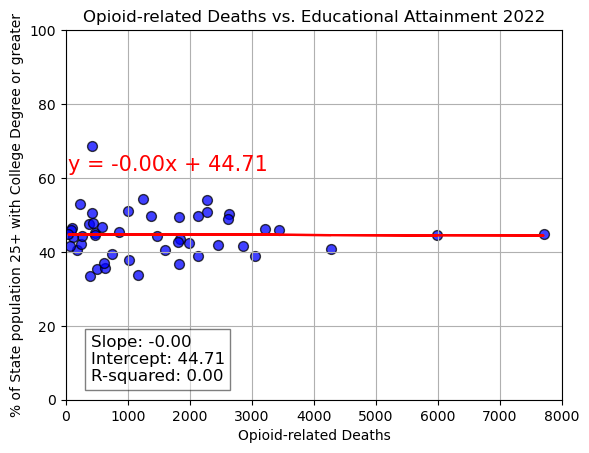

In [16]:
# Create a scatter plot and run regression for the 2022 opioid-related deaths vs. % College Degree or Greater

# Extract x and y values from the DataFrame for the scatter plot
x_values = merged_opioid_education_2022["Total Opioid Deaths"]
y_values = merged_opioid_education_2022["College Degree or greater"]

# Convert to NumPy arrays and ensure they are of type float
try:
    x_values = np.array(x_values, dtype=float)
    y_values = np.array(y_values, dtype=float)
except ValueError as e:
    print("Error converting data to float:", e)
    # Handle or clean your data here

# Check for NaN values and remove them
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]

# Create a scatter plot of opioid-related deaths vs. median household income
plt.scatter(x_values, y_values,
            marker="o",
            facecolors="blue",
            edgecolors="black",
            s=50,
            alpha=0.75)

# Perform linear regression on the data
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the regression line values based on the slope and intercept
regress_values = slope * x_values + intercept

# Create a string for the regression line equation
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"

# Plot the regression line on the scatter plot
plt.plot(x_values, regress_values, "r-", label=f"Fit: {line_eq}")

# Annotate the plot with the regression line equation
plt.annotate(line_eq, 
             (x_values.min(), y_values.max() * 0.9),
             fontsize=15, 
             color="red")

# Add text for the regression statistics
stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {rvalue**2:.2f}"
plt.text(0.05, 0.05, stats_text, fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Set the y-axis and x-axis limits
plt.ylim(0, 100)
plt.xlim(0, 8000)

# Label the x-axis and y-axis, set the title and add a grid
plt.xlabel("Opioid-related Deaths")
plt.ylabel("% of State population 25+ with College Degree or greater")
plt.title("Opioid-related Deaths vs. Educational Attainment 2022")
plt.grid(True)

# Save the plot as an image file
plt.savefig('Data/opioid_education_college_2022.png', bbox_inches='tight')

# Display the plot
plt.show()

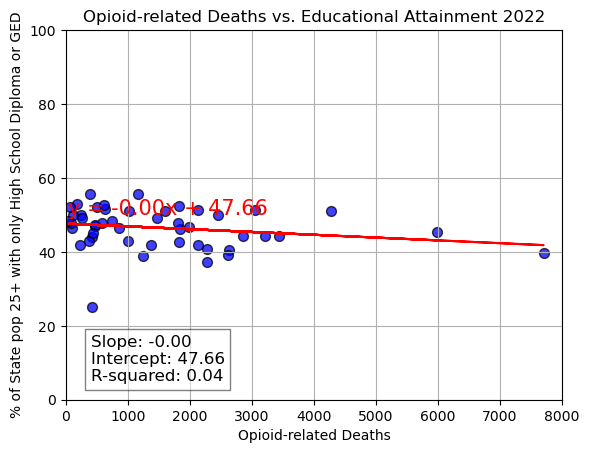

In [17]:
# Create a scatter plot and run regression for the 2022 opioid-related deaths vs. % Only High School Degree or GED

# Extract x and y values from the DataFrame for the scatter plot
x_values = merged_opioid_education_2022["Total Opioid Deaths"]
y_values = merged_opioid_education_2022["High School Diploma or GED"]

# Convert to NumPy arrays and ensure they are of type float
try:
    x_values = np.array(x_values, dtype=float)
    y_values = np.array(y_values, dtype=float)
except ValueError as e:
    print("Error converting data to float:", e)
    # Handle or clean your data here

# Check for NaN values and remove them
mask = ~np.isnan(x_values) & ~np.isnan(y_values)
x_values = x_values[mask]
y_values = y_values[mask]

# Create a scatter plot of opioid-related deaths vs. median household income
plt.scatter(x_values, y_values,
            marker="o",
            facecolors="blue",
            edgecolors="black",
            s=50,
            alpha=0.75)

# Perform linear regression on the data
slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)

# Calculate the regression line values based on the slope and intercept
regress_values = slope * x_values + intercept

# Create a string for the regression line equation
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"

# Plot the regression line on the scatter plot
plt.plot(x_values, regress_values, "r-", label=f"Fit: {line_eq}")

# Annotate the plot with the regression line equation
plt.annotate(line_eq, 
             (x_values.min(), y_values.max() * 0.9),
             fontsize=15, 
             color="red")

# Add text for the regression statistics
stats_text = f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {rvalue**2:.2f}"
plt.text(0.05, 0.05, stats_text, fontsize=12, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Set the y-axis and x-axis limits
plt.ylim(0, 100)
plt.xlim(0, 8000)

# Label the x-axis and y-axis, set the title and add a grid
plt.xlabel("Opioid-related Deaths")
plt.ylabel("% of State pop 25+ with only High School Diploma or GED")
plt.title("Opioid-related Deaths vs. Educational Attainment 2022")
plt.grid(True)

# Save the plot as an image file
plt.savefig('Data/opioid_education_highschoolGED_2022.png', bbox_inches='tight')

# Display the plot
plt.show()
